In [22]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

from argparse import Namespace
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import build_colored_target_black_reference_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator, build_differet_shapes_stimulus_generator
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION
from simple_relational_reasoning.embeddings.models import build_model
from simple_relational_reasoning.embeddings.task import AccuracyMetric, run_multiple_models_multiple_generators
import run_embeddings




In [23]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if row == 0:
                if col == k - 1:
                    ax.set_title('Different Relation')
                elif col == k - 2:
                    ax.set_title('Same Relation')
                else:
                    ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    plt.show()


METRICS = (AccuracyMetric('Accuracy', pair_only=True), )


def run_minimal_task(model, triplets, batch_size=None, metrics=METRICS):
    device = next(model.parameters()).device

    if batch_size is None:
        batch_size = triplets.shape[0]

    B = batch_size
    dataloader = DataLoader(TensorDataset(triplets), batch_size=batch_size, shuffle=False)

    model_results = defaultdict(list)
    cosines = []
    cos = nn.CosineSimilarity(dim=-1)
    triangle_indices = np.triu_indices(3, 1)
    
    model.eval()

    for b in dataloader:
        x = b[0]  # shape (B, H + 2, 3, 224, 224) where H is the number of habituation stimuli
        H = x.shape[1] - 2
        x = x.view(-1, *x.shape[2:])
        x = x.to(device)
        e = model(x).detach()
        e = e.view(B, H + 2, -1)  # shape (B, H + 2, Z)

        if H > 1:  # if we have multiple habituation stimuli, average them
            average_habituation_embedding = e[:, :-2, :].mean(dim=1, keepdim=True)
            test_embeddings = e[:, -2:]
            e = torch.cat((average_habituation_embedding, test_embeddings), dim=1)

        embedding_pairwise_cosine = cos(e[:, :, None, :], e[:, None, :, :])  # shape (B, 3, 3)
        triplet_cosines = embedding_pairwise_cosine[:, triangle_indices[0], triangle_indices[1]]
        cosines.append(triplet_cosines.cpu())

        for metric in metrics:
            model_results[metric.name].append(metric(triplet_cosines).cpu())

    return torch.cat(cosines), torch.cat(model_results['Accuracy']).cpu()

def plot_triplets_with_model_scores(model, triplets, batch_size=None, metrics=METRICS):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    cosines, accuracies = run_minimal_task(model, triplets, batch_size=batch_size, metrics=metrics)

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            # if row == 0:
            #     if col == k - 1:
            #         ax.set_title('Different Relation')
            #     elif col == k - 2:
            #         ax.set_title('Same Relation')
            #     else:
            #         ax.set_title(f'Habituation #{col + 1}')

            if col == k - 2:
                ax.set_title(f'{cosines[row, 0].item():.4e}', 
                    fontdict={'color': 'blue' if accuracies[row].item() else 'black'})
            
            elif col == k - 1:
                ax.set_title(f'{cosines[row, 1].item():.4e}', 
                    fontdict={'color': 'black' if accuracies[row].item() else 'blue'})

    fig.subplots_adjust(wspace=0.025, top=0.95)
    plt.suptitle(f'Overall accuracy: {accuracies.mean().item():.2f}', fontsize=16)
    plt.show()

    return cosines, accuracies


GENERATOR_NAMES = ('color bar', 'split text', 'random colors')


def create_stimulus_generators_and_names(names=GENERATOR_NAMES, seed=None, **kwargs):
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))

    generators = (
        build_colored_target_black_reference_stimulus_generator(rng=rng, **kwargs), 
        build_split_text_stimulus_generator(
            # reference_box_size=10,
            # total_reference_size=(10, 140), n_reference_patches=8,
            # reference_patch_kwargs=dict(ylim=(-70, 70)),
            rng=rng, **kwargs),
        # build_random_color_stimulus_generator(rn=rng, **kwargs)
    )
    
    return zip(generators, names)

In [24]:
BASELINE_TRIPLET_KWARGS = dict(n_target_types=2, extra_diagonal_margin=0)
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (50, 80),
    (True, True): (40, 80),  
}

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

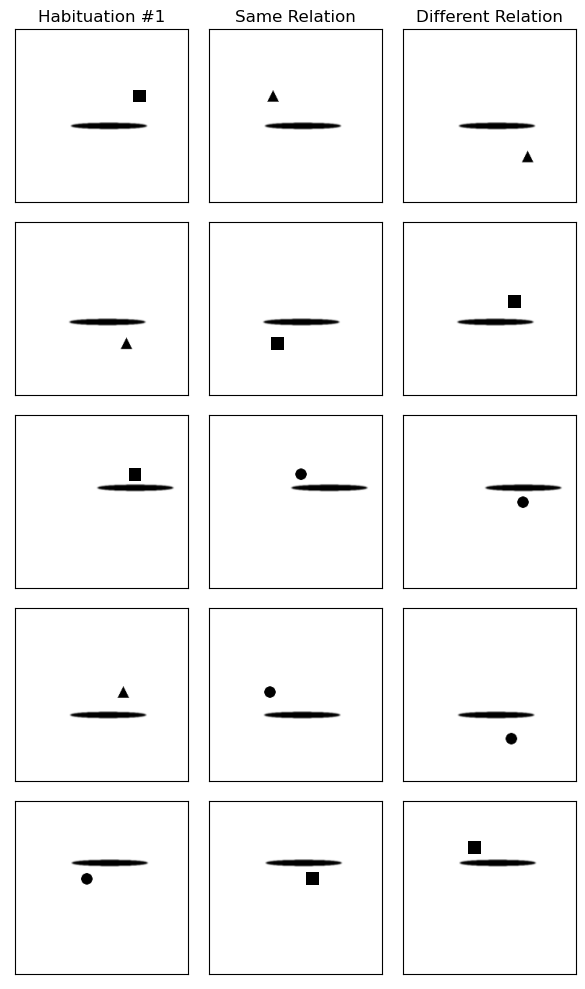

In [29]:
terminal_reference = torch.load('/Users/guydavidson/projects/simple-relational-reasoning/temp/split_text_ref.dat')
terminal_targets = torch.load('/Users/guydavidson/projects/simple-relational-reasoning/temp/split_text_targets.dat')

# plt.imshow(stimulus_generator.reference_arr.permute(1, 2, 0).numpy())
# plt.imshow(stimulus_generator.targets_arrs[0].permute(1, 2, 0).numpy())
# plt.imshow(terminal_reference.permute(1, 2, 0).numpy())
triplets = triplet_generator(10, normalize=False)
plot_triplets(triplets[:5])

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7FDA78E18130}


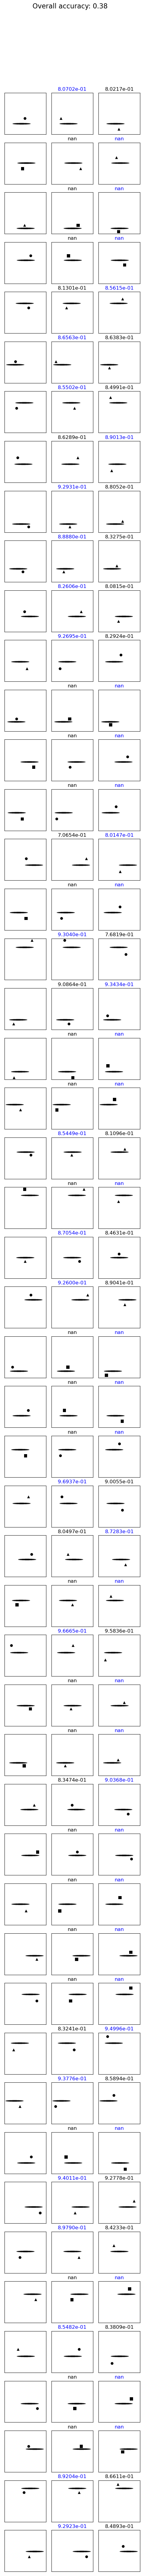

(tensor([[0.8070, 0.8022, 0.9761],
         [   nan,    nan, 0.9237],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [0.8130, 0.8561, 0.9089],
         [0.8656, 0.8638, 0.9401],
         [0.8550, 0.8499, 0.9391],
         [0.8629, 0.8901, 0.9583],
         [0.9293, 0.8805, 0.9363],
         [0.8888, 0.8328, 0.9236],
         [0.8261, 0.8081, 0.9474],
         [0.9270, 0.8292, 0.9137],
         [   nan,    nan,    nan],
         [   nan,    nan, 0.9379],
         [   nan,    nan, 0.9273],
         [0.7065, 0.8015, 0.9100],
         [   nan,    nan, 0.9339],
         [0.9304, 0.7682, 0.8906],
         [0.9086, 0.9343, 0.9325],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [0.8545, 0.8110, 0.8602],
         [   nan,    nan, 0.8953],
         [0.8705, 0.8463, 0.9142],
         [0.9260, 0.8904, 0.9354],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan, 0.9354],
         [0.9694, 0.

In [31]:
model = build_model('mobilenet', device=device, pretrained=True)

seed = np.random.randint(0, 2**32)
rng = np.random.default_rng(seed)
stimulus_generator = build_differet_shapes_stimulus_generator(rng=rng)

triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints_dict[(False, False)],
                relation=ABOVE_BELOW_RELATION, two_reference_objects=False,
                adjacent_reference_objects=False, seed=seed, **BASELINE_TRIPLET_KWARGS)

    
triplets = triplet_generator(50)
plot_triplets_with_model_scores(model, triplets, batch_size=5)

In [ ]:
seed = np.random.randint(0, 2**32)
two_reference_objects = True
adjacent_reference_objects = False
stimulus_generators = ['split_text']

args = Namespace(
    triplet_generator='quinn',
    stimulus_generators=stimulus_generators,
    stimulus_generator_kwargs=dict(
        seed=seed,
        rng=np.random.default_rng(seed),
        rotate_angle=None,
    ),
    distance_endpoints=distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)],
    relation=BETWEEN_RELATION,
    two_reference_objects=two_reference_objects,
    adjacent_reference_objects=adjacent_reference_objects,
    n_target_types=2,
    transpose_stimuli=False,
    multiple_habituation_radius=10,
    n_habituation_stimuli=1,
    extra_diagonal_margin=0,
)

triplet_generators = run_embeddings.create_triplet_generators(args)
triplet_generator = triplet_generators[0]

triplets = triplet_generator(50, normalize=True)
plot_triplets_with_model_scores(model, triplets)



In [ ]:
model_names = ['mobilenet-imagenet']
model_kwarg_dicts = [dict(name='mobilenet', device=device, pretrained=True)]
output = run_multiple_models_multiple_generators(
            model_names, model_kwarg_dicts, stimulus_generators, 
            triplet_generators, 100, 5)

output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

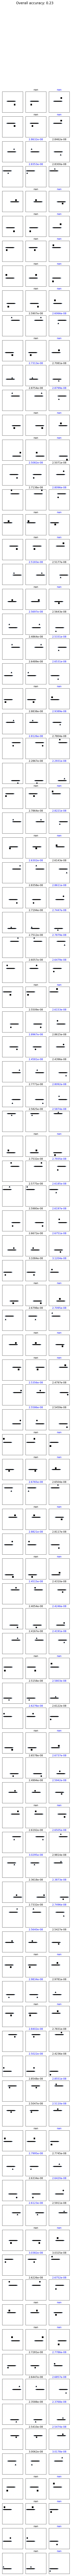

In [5]:
model = build_model('mobilenet', device=device, pretrained=False)

# seed = np.random.randint(0, 2**32)
# rng = np.random.default_rng(seed)
# stimulus_generator = build_split_text_stimulus_generator(rng=rng)

# triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints_dict[(True, False)],
#                 relation=BETWEEN_RELATION, two_reference_objects=True,
#                 adjacent_reference_objects=False, seed=seed, **BASELINE_TRIPLET_KWARGS)

    
# triplets = triplet_generator(50, normalize=True)

data = torch.load('/Users/guydavidson/projects/simple-relational-reasoning/temp/data_dump_11.dat')
cosines, accuracies = plot_triplets_with_model_scores(model, data, batch_size=8)


# Stimulus conditions we have
* Above/below
    * With two reference objects
        * With or without a gap between them
* Between
* *The above two relations, but sideways (left/right and vertical between)* -- currently not plotted because it's just the regular stimuli transposed, but I can add that demo.
* Diagonal
* With both generators above



In [ ]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in create_stimulus_generators_and_names():
            
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

            adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
            title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
            display(Markdown(f'## {title}'))
            triplets = triplet_generator(N_examples, normalize=False)
            plot_triplets(triplets)
            display(Markdown('----'))


In [ ]:
relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Between/Outside'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for stimulus_generator, generator_name in create_stimulus_generators_and_names():
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation}'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))


In [ ]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for rotate_angle in (30, 45, 60):
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
        # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
        title = f'{generator_name} | {relation} | {rotate_angle} degrees'
        display(Markdown(f'## {title}'))
        triplets = triplet_generator(N_examples, normalize=False)
        plot_triplets(triplets)
        display(Markdown('----'))


Note for the above: we could obviously run all of the different variations of above/below (two reference objects, what sort of gap betwen them, etc.) on the diagonal case as well, if we wanted to.

Similarly, we could run between/outside diagonally, too.

Not plotted but also exist are the left/right and vertical between stimuli, which are just the non-diagonal stimuli transposed. 

Let me know if you want me to plot any of the above.

### TODO:
One significant things is still missing here:
1. I haven't finished implementing the condition where we create more than one habituation stimulus.

In [ ]:
relation = BETWEEN_RELATION
distance_endpoints = (40, 80)
N_examples = 5
n_habituation_stimuli = 4

display(Markdown('# Multiple Habituation Stimuli'))

rng = np.random.default_rng(n_habituation_stimuli)
stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=60)
# stimulus_generator = build_random_color_stimulus_generator(rng=rng)

triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
    relation=relation, two_reference_objects=True, 
    adjacent_reference_objects=False, n_habituation_stimuli=n_habituation_stimuli,
    **BASELINE_TRIPLET_KWARGS)

# adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
# title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
title = f'{n_habituation_stimuli} habituation stimuli'
display(Markdown(f'## {title}'))
triplets = triplet_generator(N_examples, normalize=False)
plot_triplets(triplets)
display(Markdown('----'))
